<a href="https://colab.research.google.com/github/Haque14/MSE504/blob/main/midterm_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MidTerm - 2 for the Fall 2024 Course "Machine Learning for Materials Science", University of Tennessee Knoxville, Department of Materials Science and Engineering.

- Instructor Sergei V. Kalinin

Special point:
- ChatGPT will augment your power as a coder
- If and only if you know what you want to accomplish!

Name: Md Ershadul Haque

Department: Mechanical, Aerospace, and Biomedical Engineering

In [ ]:
pip install torch torchvision numpy matplotlib scikit-image


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 6.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=e7ea591822f7973e85e30339e37c03feac1d9b4d9ad337baefcc27193aba4eff
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


# 1.Out-of-distribution effects

Explore the out of distribution effects in VAE.
- Build the VAE or AE denoiser
- Train it on the digits [0-5]
- Quantufy performance on the digits that it was trained on (e.g. vis SSID of ground truth vs reconstruction as a function of noise)
- Quantify performance for digits [6-9]

Using device: cuda
Data directory created.
Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 18.1MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 469kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 4.37MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.28MB/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Epoch [1/20], Loss: 174.5869
Epoch [2/20], Loss: 131.6330
Epoch [3/20], Loss: 120.7113
Epoch [4/20], Loss: 114.4494
Epoch [5/20], Loss: 110.9039
Epoch [6/20], Loss: 108.7318
Epoch [7/20], Loss: 107.2316
Epoch [8/20], Loss: 106.1495
Epoch [9/20], Loss: 105.1862
Epoch [10/20], Loss: 104.4831
Epoch [11/20], Loss: 103.8398
Epoch [12/20], Loss: 103.3087
Epoch [13/20], Loss: 102.7700
Epoch [14/20], Loss: 102.3291
Epoch [15/20], Loss: 102.0103
Epoch [16/20], Loss: 101.6708
Epoch [17/20], Loss: 101.3409
Epoch [18/20], Loss: 101.0684
Epoch [19/20], Loss: 100.7826
Epoch [20/20], Loss: 100.5554
SSIM for In-Distribution Data (digits 0-5): 0.8339
SSIM for OOD Data (digits 6-9): 0.7088


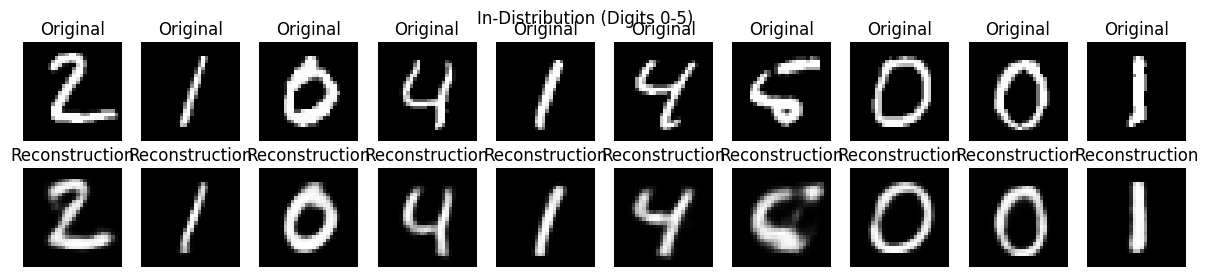

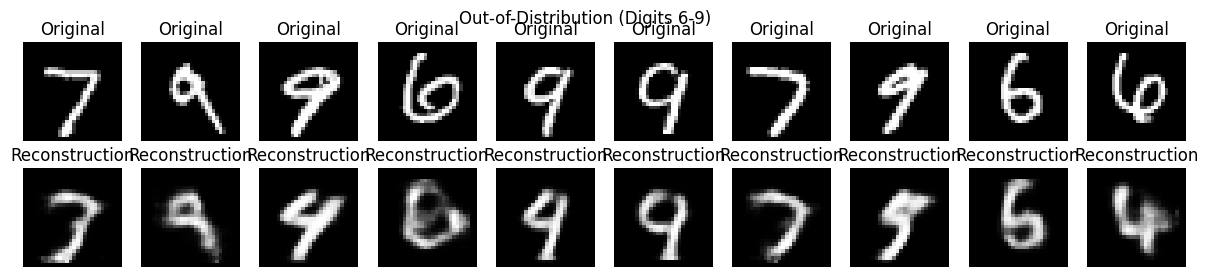

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader, Subset
from skimage.metrics import structural_similarity as ssim
import numpy as np
import matplotlib.pyplot as plt

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Directory for MNIST data
data_dir = "./data/MNIST/raw/"

# Check if MNIST data already exists to avoid re-downloading
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print("Data directory created.")

# Helper function for manual download instructions
def manual_download_instructions():
    print("\nAutomatic download failed. Please manually download the MNIST dataset from these links:")
    print("1. Train images: https://ossci-datasets.s3.amazonaws.com/mnist/train-images-idx3-ubyte.gz")
    print("2. Train labels: https://ossci-datasets.s3.amazonaws.com/mnist/train-labels-idx1-ubyte.gz")
    print("3. Test images: https://ossci-datasets.s3.amazonaws.com/mnist/t10k-images-idx3-ubyte.gz")
    print("4. Test labels: https://ossci-datasets.s3.amazonaws.com/mnist/t10k-labels-idx1-ubyte.gz")
    print("\nPlace these files in the './data/MNIST/raw/' directory and extract them using:")
    print("gzip -d ./data/MNIST/raw/*.gz")

# Data Preparation
transform = transforms.Compose([transforms.ToTensor()])

try:
    # Load MNIST dataset
    mnist_train = MNIST(root="./data", train=True, transform=transform, download=True)
    mnist_test = MNIST(root="./data", train=False, transform=transform, download=True)
except Exception as e:
    print(f"Error during MNIST dataset download: {e}")
    manual_download_instructions()
    exit()

# Helper function to filter digits
def filter_digits(dataset, digits):
    indices = [i for i, (img, label) in enumerate(dataset) if label in digits]
    return Subset(dataset, indices)

# Create in-distribution (digits 0-5) and OOD (digits 6-9) datasets
train_in_dist = filter_digits(mnist_train, digits=[0, 1, 2, 3, 4, 5])
test_in_dist = filter_digits(mnist_test, digits=[0, 1, 2, 3, 4, 5])
test_ood = filter_digits(mnist_test, digits=[6, 7, 8, 9])

# Data loaders
batch_size = 64
train_loader = DataLoader(train_in_dist, batch_size=batch_size, shuffle=True)
test_in_loader = DataLoader(test_in_dist, batch_size=batch_size, shuffle=False)
test_ood_loader = DataLoader(test_ood, batch_size=batch_size, shuffle=False)

# Define VAE Model
class VAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(),
            nn.Linear(400, 100),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(100, latent_dim)
        self.fc_logvar = nn.Linear(100, latent_dim)
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 100),
            nn.ReLU(),
            nn.Linear(100, 400),
            nn.ReLU(),
            nn.Linear(400, 28 * 28),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Loss Function
def vae_loss(recon_x, x, mu, logvar):
    bce = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce + kl_div

# Initialize model, optimizer
latent_dim = 20
vae = VAE(latent_dim).to(device)
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training Loop
epochs = 20
for epoch in range(epochs):
    vae.train()
    train_loss = 0
    for x, _ in train_loader:
        x = x.view(-1, 28 * 28).to(device)
        optimizer.zero_grad()
        recon_x, mu, logvar = vae(x)
        loss = vae_loss(recon_x, x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    avg_loss = train_loss / len(train_loader.dataset)
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

# Evaluation Function (SSIM Metric)
def evaluate_model(data_loader):
    vae.eval()
    ssim_scores = []
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(-1, 28 * 28).to(device)
            recon_x, _, _ = vae(x)
            x = x.view(-1, 28, 28).cpu().numpy()
            recon_x = recon_x.view(-1, 28, 28).cpu().numpy()
            for i in range(x.shape[0]):
                score = ssim(x[i], recon_x[i], data_range=1.0)
                ssim_scores.append(score)
    return np.mean(ssim_scores)

# Evaluate on in-distribution and OOD data
in_dist_ssim = evaluate_model(test_in_loader)
ood_ssim = evaluate_model(test_ood_loader)

print(f"SSIM for In-Distribution Data (digits 0-5): {in_dist_ssim:.4f}")
print(f"SSIM for OOD Data (digits 6-9): {ood_ssim:.4f}")

# Visualize Reconstructions
def visualize_reconstructions(data_loader, title):
    vae.eval()
    with torch.no_grad():
        for x, _ in data_loader:
            x = x.view(-1, 28 * 28).to(device)
            recon_x, _, _ = vae(x)
            x = x.view(-1, 28, 28).cpu().numpy()
            recon_x = recon_x.view(-1, 28, 28).cpu().numpy()
            fig, axes = plt.subplots(2, 10, figsize=(15, 3))
            for i in range(10):
                axes[0, i].imshow(x[i], cmap='gray')
                axes[0, i].set_title("Original")
                axes[0, i].axis('off')
                axes[1, i].imshow(recon_x[i], cmap='gray')
                axes[1, i].set_title("Reconstruction")
                axes[1, i].axis('off')
            plt.suptitle(title)
            plt.show()
            break

# Visualize reconstructions for in-distribution and OOD data
visualize_reconstructions(test_in_loader, "In-Distribution (Digits 0-5)")
visualize_reconstructions(test_ood_loader, "Out-of-Distribution (Digits 6-9)")


# 2.Explainable ML

- Build the classified for the fashion MNIST data set
- Use LIME or SHAP to explain the predictions

Using device: cuda


100%|██████████| 26.4M/26.4M [00:02<00:00, 12.7MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 205kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.31MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 21.7MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Epoch [1/10], Loss: 0.4724
Epoch [2/10], Loss: 0.3032
Epoch [3/10], Loss: 0.2568
Epoch [4/10], Loss: 0.2208
Epoch [5/10], Loss: 0.1978
Epoch [6/10], Loss: 0.1762
Epoch [7/10], Loss: 0.1575
Epoch [8/10], Loss: 0.1411
Epoch [9/10], Loss: 0.1250
Epoch [10/10], Loss: 0.1074
Test Accuracy: 91.28%


  0%|          | 0/1000 [00:00<?, ?it/s]

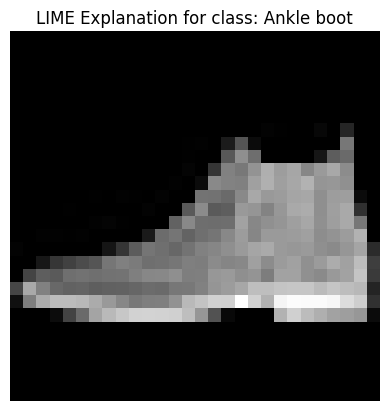

In [ ]:
# Check and install necessary packages
import subprocess
import sys

def install(package):
    try:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])
    except subprocess.CalledProcessError:
        print(f"Failed to install {package}. Please try running '!pip install {package}' manually in your notebook.")

# Install missing packages
try:
    import torch
    import torchvision
except ImportError:
    install("torch torchvision")

try:
    import lime
except ImportError:
    print("Installing LIME...")
    install("lime")
    import lime

try:
    import shap
except ImportError:
    print("Installing SHAP...")
    install("shap")
    import shap

# Now continue with the main code
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import FashionMNIST
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_image
from skimage.segmentation import mark_boundaries

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = FashionMNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = FashionMNIST(root="./data", train=False, transform=transform, download=True)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Define the neural network model
class FashionClassifier(nn.Module):
    def __init__(self):
        super(FashionClassifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
       x = self.pool(F.relu(self.conv1(x)))
       x = self.pool(F.relu(self.conv2(x)))
       x = x.reshape(x.size(0), -1)  # Use .reshape() instead of .view()
       x = F.relu(self.fc1(x))
       x = self.fc2(x)
       return x

# Initialize model, loss function, and optimizer
model = FashionClassifier().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Epoch [{epoch+1}/{epochs}], Loss: {running_loss / len(train_loader):.4f}")

# Evaluation function
def evaluate(model, loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Evaluate on test data
test_accuracy = evaluate(model, test_loader)
print(f"Test Accuracy: {test_accuracy:.2f}%")

# Class labels for Fashion MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Explanation with LIME
def explain_with_lime(model, image, label):
    explainer = lime_image.LimeImageExplainer()

    def predict(images):
        # Convert RGB images (3 channels) back to grayscale (1 channel)
        images = np.mean(images, axis=3, keepdims=True)
        images = torch.tensor(images).permute(0, 3, 1, 2).to(device).float()
        outputs = model(images)
        probs = F.softmax(outputs, dim=1).cpu().detach().numpy()
        return probs

    explanation = explainer.explain_instance(
        image.numpy().squeeze(), predict, top_labels=1, hide_color=0, num_samples=1000
    )
    temp, mask = explanation.get_image_and_mask(
        label, positive_only=True, num_features=10, hide_rest=False
    )
    plt.imshow(mark_boundaries(temp, mask))
    plt.title(f"LIME Explanation for class: {class_names[label]}")
    plt.axis('off')
    plt.show()

# Get a sample from the test set
image, label = test_dataset[0]
image = image.unsqueeze(0).to(device)

# LIME Explanation
explain_with_lime(model, image.cpu(), label)




# 3.Molecular discovery

- We extract information from QM9 dataset, particularly from each molecule (given orignially in .xyz format) followed by computing features using rdkit and then combine those into a dataframe.
- Link to orginal dataset: http://quantum-machine.org/datasets/
- Link where we can find the functionalities represented by variables in the 'parser' code. For example 'mu' represents the dipole moment. https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.datasets.QM9.html

- Adapted from notebook prepared by Ayana Ghosh, research.aghosh@gmail.com

## Install RDkit and Selfies

In [ ]:
!pip install rdkit-pypi
!pip install selfies --upgrade

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 68.2 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd

import glob

import rdkit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors

import torch
from math import log
import matplotlib.pyplot as plt
from pandas import json_normalize

import selfies as sf

In [ ]:
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

def parse_xyz(filename):
    """
    Parses QM9 specific xyz files.
    :param filename: str path to file
    :return:
    """
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    harmonic_vibrational_frequencies = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 2:
                harmonic_vibrational_frequencies = [float(i) for i in line.split()]
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    result = {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'harmonic_oscillator_frequencies': harmonic_vibrational_frequencies,
        'smiles': smiles,
        'inchi': inchi
    }
    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties = dict(zip(scalar_property_labels, scalar_properties))
    result.update(scalar_properties)
    return result

## Download the data

In [ ]:
!gdown https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF

Downloading...
From (original): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF
From (redirected): https://drive.google.com/uc?id=1At3XHtaXXY3Qr4RIQ1Vua2_dRKoGyyEF&confirm=t&uuid=94b29af5-12d7-45d1-890b-527e46230b18
To: /content/dsgdb9nsd.xyz.tar.bz2
100% 86.1M/86.1M [00:01<00:00, 46.2MB/s]


Generate lists of SMILE strings and append with properties that we can directly retrieve from the QM9 dataset

In [ ]:
import os
import glob
import numpy as np
import pandas as pd
import torch
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import MolFromSmiles

# Define the path to the extracted QM9 .xyz files
xyz_files_path = "./qm9_data/gdb9_xyz/"

# Function to parse float with scientific notation handling
def parse_float(s: str) -> float:
    try:
        return float(s)
    except ValueError:
        base, power = s.split('*^')
        return float(base) * 10**float(power)

# Function to parse .xyz files from QM9 dataset
def parse_xyz(filename):
    num_atoms = 0
    scalar_properties = []
    atomic_symbols = []
    xyz = []
    charges = []
    smiles = ''
    inchi = ''
    with open(filename, 'r') as f:
        for line_num, line in enumerate(f):
            if line_num == 0:
                num_atoms = int(line)
            elif line_num == 1:
                scalar_properties = [float(i) for i in line.split()[2:]]
            elif 2 <= line_num <= 1 + num_atoms:
                atom_symbol, x, y, z, charge = line.split()
                atomic_symbols.append(atom_symbol)
                xyz.append([parse_float(x), parse_float(y), parse_float(z)])
                charges.append(parse_float(charge))
            elif line_num == num_atoms + 3:
                smiles = line.split()[0]
            elif line_num == num_atoms + 4:
                inchi = line.split()[0]

    scalar_property_labels = ['A', 'B', 'C', 'mu', 'alpha', 'homo', 'lumo', 'gap', 'r2', 'zpve', 'u0', 'u', 'h', 'g', 'cv']
    scalar_properties_dict = dict(zip(scalar_property_labels, scalar_properties))

    return {
        'num_atoms': num_atoms,
        'atomic_symbols': atomic_symbols,
        'pos': torch.tensor(xyz),
        'charges': np.array(charges),
        'smiles': smiles,
        'inchi': inchi,
        **scalar_properties_dict
    }

# Function to generate a list of SMILES and append properties
def generate_smiles_with_properties(xyz_files_path):
    data = []
    for filename in glob.glob(os.path.join(xyz_files_path, "*.xyz")):
        parsed_data = parse_xyz(filename)
        smiles = parsed_data.get('smiles', '')

        if smiles:
            # Validate the SMILES string using RDKit
            mol = Chem.MolFromSmiles(smiles)
            if mol is not None:
                properties = {
                    'SMILES': smiles,
                    'InChI': parsed_data.get('inchi', ''),
                    'HOMO': parsed_data.get('homo', np.nan),
                    'LUMO': parsed_data.get('lumo', np.nan),
                    'Gap': parsed_data.get('gap', np.nan),
                    'DipoleMoment': parsed_data.get('mu', np.nan),
                    'Polarizability': parsed_data.get('alpha', np.nan),
                    'MolecularWeight': Descriptors.MolWt(mol),
                    'LogP': Descriptors.MolLogP(mol),
                    'NumAtoms': parsed_data.get('num_atoms', 0)
                }
                data.append(properties)

    # Create a DataFrame from the extracted data
    df = pd.DataFrame(data)
    return df

# Generate the DataFrame and save it
smiles_df = generate_smiles_with_properties(xyz_files_path)
print(smiles_df.head())

# Save to a CSV file
smiles_df.to_csv("qm9_smiles_with_properties.csv", index=False)
print("Data saved to 'qm9_smiles_with_properties.csv'.")


Empty DataFrame
Columns: []
Index: []
Data saved to 'qm9_smiles_with_properties.csv'.


What are SMILES and when were they invented (note that ChatGPT is unlikely to produce the correct citation - so Wikipedia can help)?

*Answer*:

**What Are SMILES?**

SMILES (Simplified Molecular Input Line Entry System) is a chemical notation system that encodes a molecule's structure as a text string. It is designed to be human-readable while also allowing for efficient storage and easy parsing by software in cheminformatics.

**When Was SMILES Invented?**

SMILES was first developed in the late 1980s by David Weininger. It was designed as a flexible and compact way to represent chemical structures for use in computational chemistry and cheminformatics. SMILES quickly became a standard notation due to its simplicity and ease of use.

**Why Use SMILES?**

SMILES is widely used in cheminformatics because:

* **Compact Representation:** It provides a simple, text-based way to represent complex molecular structures.
* **Interoperability:** SMILES strings can be used as input for various software tools and databases.
* **Machine Readable:** It is easily parsed by software, enabling efficient processing and analysis of chemical data.

In [ ]:
!mkdir /content/Molecules
!tar -C Molecules -xvf /content/dsgdb9nsd.xyz.tar.bz2

Streaming output truncated to the last 5000 lines.
dsgdb9nsd_128886.xyz
dsgdb9nsd_128887.xyz
dsgdb9nsd_128888.xyz
dsgdb9nsd_128889.xyz
dsgdb9nsd_128890.xyz
dsgdb9nsd_128891.xyz
dsgdb9nsd_128892.xyz
dsgdb9nsd_128893.xyz
dsgdb9nsd_128894.xyz
dsgdb9nsd_128895.xyz
dsgdb9nsd_128896.xyz
dsgdb9nsd_128897.xyz
dsgdb9nsd_128898.xyz
dsgdb9nsd_128899.xyz
dsgdb9nsd_128900.xyz
dsgdb9nsd_128901.xyz
dsgdb9nsd_128902.xyz
dsgdb9nsd_128903.xyz
dsgdb9nsd_128904.xyz
dsgdb9nsd_128905.xyz
dsgdb9nsd_128906.xyz
dsgdb9nsd_128907.xyz
dsgdb9nsd_128908.xyz
dsgdb9nsd_128909.xyz
dsgdb9nsd_128910.xyz
dsgdb9nsd_128911.xyz
dsgdb9nsd_128912.xyz
dsgdb9nsd_128913.xyz
dsgdb9nsd_128914.xyz
dsgdb9nsd_128915.xyz
dsgdb9nsd_128916.xyz
dsgdb9nsd_128917.xyz
dsgdb9nsd_128918.xyz
dsgdb9nsd_128919.xyz
dsgdb9nsd_128920.xyz
dsgdb9nsd_128921.xyz
dsgdb9nsd_128922.xyz
dsgdb9nsd_128923.xyz
dsgdb9nsd_128924.xyz
dsgdb9nsd_128925.xyz
dsgdb9nsd_128926.xyz
dsgdb9nsd_128927.xyz
dsgdb9nsd_128928.xyz
dsgdb9nsd_128929.xyz
dsgdb9nsd_128930.xyz
dsgd

In [ ]:
smiles = []
enthalpy = []
u0 = []
u = []
g = []
alpha = []
r2 = []
mu = []

#may need to change the path
filenames = glob.glob('/content/Molecules/*.xyz')

#may need to go through the full range
for fid in range(5000):
    x = parse_xyz(filenames[fid])
    smiles_loc = x['smiles']
    enthalpy_loc = x['h']
    dipole_moment = x['mu']
    homo_loc = x['homo']
    lumo_loc = x['lumo']
    gap_loc = x['gap']
    zpve_loc = x['zpve']
    u0_loc = x['u0']
    u_loc = x['u']
    g_loc = x['g']
    alpha_loc = x['alpha']
    r2_loc = x['r2']
    smiles.append(smiles_loc)
    mu.append(dipole_moment)
    enthalpy.append(enthalpy_loc)
    u0.append(u0_loc)
    u.append(u_loc)
    g.append(g_loc)
    alpha.append(alpha_loc)
    r2.append(r2_loc)

Let's compute few basic features and put together a dataset. Features we compute:
- molecular weight,
- topological polar surface area,
- molar log P,
- number of hydrogen bond donors,
- acceptors,
- valence electrons,
- maximum partial charge,
- minimum partial charge,
- number of rotatable bonds,
- number of ring counts,
- number of stereocenters

In [ ]:
mol_wt, tpsa, logp_ml, hbd, hba  = [], [], [], [], []
vale, partialcg_max, partialcg_min, rotbd, ringct, stereoct = [], [], [], [], [], []

for i in range(len(smiles)):
    m = Chem.MolFromSmiles(smiles[i])
    mol_wt_l = Descriptors.ExactMolWt(m)
    tpsa_l, logp_l = Descriptors.TPSA(m), Descriptors.MolLogP(m)
    hbd_l, hba_l = Descriptors.NumHDonors(m), Descriptors.NumHAcceptors(m)
    vale_l = Descriptors.NumValenceElectrons(m),
    partialcharge_max_l, partialcharge_min_l = Descriptors.MaxPartialCharge(m), Descriptors.MinPartialCharge(m)
    rotbd_l = Descriptors.NumRotatableBonds(m)
    ring_ct, stereo_cent = Descriptors.RingCount(m), rdMolDescriptors.CalcNumAtomStereoCenters(m)

    mol_wt.append(mol_wt_l)
    tpsa.append(tpsa_l)
    logp_ml.append(logp_l)
    hbd.append(hbd_l)
    hba.append(hba_l)
    vale.append(vale_l)
    partialcg_max.append(partialcharge_max_l)
    partialcg_min.append(partialcharge_min_l)
    rotbd.append(rotbd_l)
    ringct.append(ring_ct)
    stereoct.append(stereo_cent)

New dataset with few features with SMILE strings

In [ ]:
df = pd.DataFrame({'smiles': smiles, 'mole_logp': logp_ml,'tpsa': tpsa, 'mol_wt' : mol_wt,
                   'hbd': hbd, 'hba':hba, 'valencee':vale, 'max_partialcharge':partialcg_max, 'min_partialcharge':partialcg_min,
                   'rotatablebd':rotbd, 'ringct':ringct, 'stereocent': stereoct, 'dipole_moment':mu})

In [ ]:
df

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
0,CC(C)(O)CC#CC=O,0.34970,37.30,126.068080,1,2,"(50,)",0.192291,-0.389478,1,0,0,4.3345
1,N=C1CN=C(NC=O)N1,-1.33113,77.34,126.054161,3,3,"(48,)",0.213311,-0.313046,1,1,0,3.5219
2,C1NC1C1=CN=NN1,-0.55100,63.51,110.059246,2,3,"(42,)",0.073876,-0.305580,1,2,1,5.9345
3,CNC(=O)C1OCC=C1,-0.31260,38.33,127.063329,1,2,"(50,)",0.252396,-0.360204,1,1,1,3.1318
4,CC1(C)C2OC1C21CO1,0.56260,21.76,126.068080,0,2,"(50,)",0.144736,-0.367236,0,4,2,3.2566
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,CC(=O)C(CO)OC=O,-0.89070,63.60,132.042259,1,4,"(52,)",0.293382,-0.454093,4,0,1,4.9680
4996,N=C1NN=CC=C1C#N,-0.23915,76.32,120.043596,2,3,"(44,)",0.156366,-0.282207,0,1,0,5.1942
4997,CC1C2(O)CC=CC12C,1.33340,20.23,124.088815,1,1,"(50,)",0.080727,-0.388344,0,2,3,1.3309
4998,CC(C)(CO)C#CC#C,0.64150,20.23,122.073165,1,1,"(48,)",0.059160,-0.394818,1,0,0,1.4537


## Convert SMILEs to SELFIEs

As an excercise, read the SELFIES paper (https://github.com/aspuru-guzik-group/selfies) and describe the difference between SMILES and SELFIEs

Answer:

**Difference Between SMILES and SELFIES**

**SMILES (Simplified Molecular Input Line Entry System):**

String Representation: Encodes molecules as a sequence of characters based on atoms and bonds.
Example: Ethanol (CCO), Benzene (C1=CC=CC=C1).
Syntax-Sensitive: The syntax of SMILES must be correct for the string to represent a valid molecule. Small changes can easily result in invalid molecules (e.g., incorrect ring closures or bond orders).
Chirality and Stereochemistry: Represented using special characters like @ for chiral centers.
Human-Readable: Designed to be compact and easy for humans to read and interpret.
Error-Prone: Creating valid SMILES strings manually can be difficult due to strict syntax rules.
SELFIES (Self-referencing Embedded Strings):
Robust Representation: Every SELFIES string is a valid molecule by design, meaning that any SELFIES string can be decoded into a chemically valid molecule.
Example: Ethanol ([C][C][O]), Benzene ([C][=C][C][=C][C][=C]).
Error-Tolerant: SELFIES can handle random mutations or errors without resulting in invalid molecules. This makes it suitable for generative models and data augmentation tasks.
Machine-Friendly: SELFIES was designed to be easier for machine learning models to interpret and manipulate, as every substring corresponds to a valid molecular component.
Chirality and Stereochemistry: Handled explicitly with unique tokens, reducing the complexity of representing stereoisomers.
Canonical Form: SELFIES can be generated deterministically, reducing variability in molecular encoding.


| **Aspect**            | **SMILES**                        | **SELFIES**                     |
|-----------------------|-----------------------------------|---------------------------------|
| **Validity**          | Not all strings are valid         | All strings are valid           |
| **Error Sensitivity** | High (syntax-sensitive)           | Low (robust to mutations)       |
| **Human Readability** | High                              | Lower                           |
| **Chirality/Stereochemistry** | Explicit but complex          | Explicit and simpler            |
| **Usage**             | Cheminformatics, databases        | Machine learning, generative models |
| **Syntax Complexity** | Complex (e.g., ring closures)     | Simplified, token-based         |
| **Canonical Form**    | Not guaranteed                   | Deterministic representation    |
| **Generative Models** | Challenging due to invalid strings| Ideal for generative models     |



In [ ]:
smiles

['CC(C)(O)CC#CC=O',
 'N=C1CN=C(NC=O)N1',
 'C1NC1C1=CN=NN1',
 'CNC(=O)C1OCC=C1',
 'CC1(C)C2OC1C21CO1',
 'OC1(COCOC1)C=O',
 'CC1CN2CC1C2C=O',
 'NC1=NC(=O)N=C(O)O1',
 'O=C1NC2CC(C2)O1',
 '[NH3+]CC(=O)NCC([O-])=O',
 'CC1(CC2(O)CC12)C#C',
 'COC(=O)CCC#N',
 'CCN1N=C(C)NC1=O',
 'CNC(=O)NC(C)C#C',
 'O=C1C2CCC3CC2C13',
 'CC1(CC1)C1CCCC1',
 'NC1=NC(=CN1)C#N',
 'CN1C2C3C1COC23C',
 'CC1(C)OC(=O)CC1=O',
 'OC1=C(CC#C)NC=C1',
 'CCC1C2C3CN3C12C',
 'CC(O)CC1=CN=CO1',
 'CC1=NC(N)=C(CO)N1',
 'CC(O)C1OC1CCO',
 'CCC(=O)C#N',
 'COC12CC(C)C1C2O',
 'O=C1CCC2OCC12',
 'CC12C3CC1C(C3)C2=O',
 'OCC(O)C1CN1',
 'CC1OC1C12CN1CC2',
 'O=C1NC2CC2C=C1',
 'NC1=C(O)N=CC(=O)O1',
 'OC12C3CCC11OC2C31',
 'N=C1NC(=O)C=NO1',
 'CC1(C)C2CC1(O)CO2',
 'N#CCCOCC1CN1',
 'CC1C2CC1C1CC21',
 'CC#CC(=O)CC(N)=O',
 'CCOC1C2C3CC2C13',
 'O=C1C2CC1N1CCC21',
 'CC1C(C)C1(C)C1CO1',
 'O=CNC1CC(=O)C=C1',
 'CC1C2C=CC3CC2C13',
 'CC(C)C1C(O)CC1=O',
 'CC12COC(CO1)C2=O',
 'O=C1CC23CCC2(C1)N3',
 'CC12CNC(C1)C(=N)O2',
 'CN1N=CC2=C1NN=C2',
 'CC1=CC(O)COCC1

The SELFIES have some limitations on acceptable bonding. So we refine the data set to remove the molecules that do not fit into supported semantic constraints.

In [ ]:
selfies_dataset = []
error_smiles = []

for i in range(len(smiles)):
    try:
        local_sf = sf.encoder(smiles[i])
        selfies_dataset.append(local_sf)
    except Exception as e:
        print(f"Error encoding SMILES at index {i}: {e}")
        error_smiles.append(smiles[i])  # Store the SMILES string that caused the error
        continue  # Skip to the next iteration

Error encoding SMILES at index 51: input violates the currently-set semantic constraints
	SMILES: NC1=CC=C(O1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 2507: input violates the currently-set semantic constraints
	SMILES: CC1=NOC(=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 3020: input violates the currently-set semantic constraints
	SMILES: CC1=C(ON=N1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 3690: input violates the currently-set semantic constraints
	SMILES: CN1C=NC(=C1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]

Error encoding SMILES at index 4502: input violates the currently-set semantic constraints
	SMILES: CC1=CC=C(O1)N(=O)=O
	Errors:
	[N with 5 bond(s) - a max. of 3 bond(s) was specified]



Let's see what these molecules are....

In [ ]:
error_smiles_set = set(error_smiles)
error_smiles_set

{'CC1=C(ON=N1)N(=O)=O',
 'CC1=CC=C(O1)N(=O)=O',
 'CC1=NOC(=C1)N(=O)=O',
 'CN1C=NC(=C1)N(=O)=O',
 'NC1=CC=C(O1)N(=O)=O'}

... how many of them are there

In [ ]:
df['smiles'].isin(error_smiles_set).sum()

5

And remove them from the dataframe

In [ ]:
df_filtered = df[~df['smiles'].isin(error_smiles_set)]
df_filtered.tail(5)

,smiles,mole_logp,tpsa,mol_wt,hbd,hba,valencee,max_partialcharge,min_partialcharge,rotatablebd,ringct,stereocent,dipole_moment
4995,CC(=O)C(CO)OC=O,-0.89070,63.60,132.042259,1,4,"(52,)",0.293382,-0.454093,4,0,1,4.9680
4996,N=C1NN=CC=C1C#N,-0.23915,76.32,120.043596,2,3,"(44,)",0.156366,-0.282207,0,1,0,5.1942
4997,CC1C2(O)CC=CC12C,1.33340,20.23,124.088815,1,1,"(50,)",0.080727,-0.388344,0,2,3,1.3309
4998,CC(C)(CO)C#CC#C,0.64150,20.23,122.073165,1,1,"(48,)",0.059160,-0.394818,1,0,0,1.4537
4999,CC1CC2OC2(C1)C#N,1.07748,36.32,123.068414,0,2,"(48,)",0.180437,-0.349964,0,2,3,4.3995


Now, let's generate one-hot encodings.

In [ ]:
#for producing corresponding one-hot vectors
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # [nop] is a special padding symbol
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}

labels = []
one_hot_vectors = []
for i in range(len(selfies_dataset)):

  label, one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx,
                                          pad_to_len=pad_to_len, enc_type="both")
  labels.append(label)
  one_hot_vectors.append(one_hot)

np.array(one_hot_vectors).shape

(4995, 21, 26)

Explore the code segment above. What is:
- alphabet
- symbol_to_idx
- what are the dimensionalities of the np.array(one_hot_vectors).shape

Answer:

**Alphabet:**

Alphabet is a set of all unique symbols that appear in the SELFIES strings of your dataset. SELFIES strings are composed of tokens (symbols) like [C], [O], [=C], [N], etc., which represent atoms, bonds, or structural information in the molecule. The alphabet is sorted and converted to a list for consistent indexing.

**symbol_to_idx:**

symbol_to_idx is a dictionary that maps each symbol in the alphabet to a unique integer index. This mapping is used to convert each symbol in a SELFIES string to a numerical index for encoding. In this example:

* [C] is mapped to index 1.
* [nop] (the padding symbol) is mapped to the last index, 4.

**what are the dimensionalities of the np.array(one_hot_vectors).shape:**

The dimensionality of np.array(one_hot_vectors).shape is (num_samples, pad_to_len, vocab_size). Here, num_samples is the total number of SELFIES strings in the dataset, pad_to_len is the length of the longest SELFIES string (to which all sequences are padded for uniformity), and vocab_size is the size of the alphabet, representing the total number of unique symbols (including the padding symbol [nop]). This structure allows each molecule to be represented as a sequence of one-hot encoded vectors, where each vector has length equal to vocab_size, indicating the presence of a specific symbol at that position in the sequence.


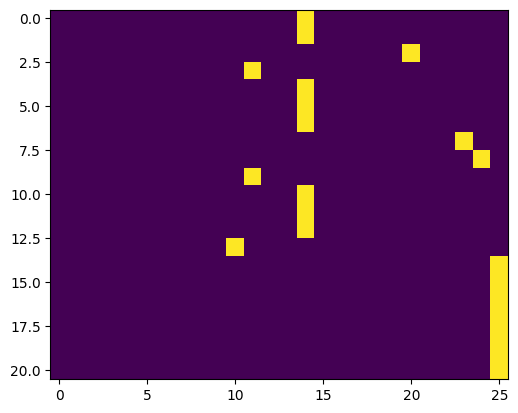

In [ ]:
plt.imshow(np.array(one_hot_vectors)[310,:,:])

Now, let's explore the properties of the latent space of this dataset. Using ChaGPT:
- Write the AE using the encoded smiles as an input with 2D latent space
-  Visualize the latent distribution and representation
- Experiment with difefrent attributes from data frame as labels, and see how they are distirbuted in latent space

In [ ]:
# Import required libraries
import selfies as sf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os

# Step 1: Provide a List of SMILES Strings (Replace with your own dataset)
smiles = [
    "CCO",  # Ethanol
    "C1=CC=CC=C1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "C[C@H](O)C",  # Lactic acid
    "N#CC",  # Acetonitrile
]

# Initialize the list for SELFIES strings
selfies_dataset = []
error_smiles = []

# Convert SMILES to SELFIES
for smile in smiles:
    try:
        selfie = sf.encoder(smile)
        selfies_dataset.append(selfie)
    except Exception as e:
        print(f"Error converting SMILES: {smile} -> {e}")
        error_smiles.append(smile)

# Check the size of the dataset
print(f"Successfully converted {len(selfies_dataset)} SMILES to SELFIES.")
print(f"Failed conversions: {len(error_smiles)}")

# Ensure we have valid SELFIES strings
if len(selfies_dataset) == 0:
    raise ValueError("No valid SELFIES strings found. Please check your input SMILES.")

# Step 2: Generate One-Hot Encodings for SELFIES Strings
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")  # Add padding symbol
alphabet = list(sorted(alphabet))
print(f"Extracted alphabet: {alphabet}")

# Determine the maximum length for padding
pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
print(f"Padding to maximum length: {pad_to_len}")

# Create a mapping from symbols to indices
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
vocab_size = len(alphabet)
print(f"Vocabulary size (alphabet length): {vocab_size}")

# Generate one-hot encodings
one_hot_vectors = []

for i in range(len(selfies_dataset)):
    try:
        # Corrected the function call to return only the one-hot encoding
        one_hot = sf.selfies_to_encoding(
            selfies=selfies_dataset[i],
            vocab_stoi=symbol_to_idx,
            pad_to_len=pad_to_len,
            enc_type="one_hot"
        )
        one_hot_vectors.append(one_hot)
    except Exception as e:
        print(f"Error encoding SELFIES at index {i}: {e}")

# Convert to a NumPy array and save
one_hot_vectors = np.array(one_hot_vectors)
print(f"Shape of one-hot vectors: {one_hot_vectors.shape}")

# Check if the one-hot vectors have the correct shape
if one_hot_vectors.ndim != 3:
    raise ValueError(f"Expected a 3D array (num_samples, pad_to_len, vocab_size), but got shape {one_hot_vectors.shape}")

# Save the one-hot vectors
np.save('one_hot_vectors.npy', one_hot_vectors)
print(f"One-hot vectors saved to 'one_hot_vectors.npy'.")

# Step 3: Load One-Hot Encoded Vectors
if os.path.exists('one_hot_vectors.npy'):
    one_hot_vectors = np.load('one_hot_vectors.npy')
    print("Loaded one-hot vectors successfully.")
else:
    raise FileNotFoundError("The file 'one_hot_vectors.npy' was not found. Please generate it first.")

# Check the shape of the one-hot encoded vectors
input_dim = one_hot_vectors.shape[2]  # vocab_size
sequence_length = one_hot_vectors.shape[1]  # pad_to_len
num_samples = one_hot_vectors.shape[0]
print(f"Shape of one-hot vectors: {one_hot_vectors.shape}")



Successfully converted 5 SMILES to SELFIES.
Failed conversions: 0
Extracted alphabet: ['[#C]', '[=Branch1]', '[=C]', '[=O]', '[Branch1]', '[C@H1]', '[C]', '[N]', '[O]', '[Ring1]', '[nop]']
Padding to maximum length: 8
Vocabulary size (alphabet length): 11
Shape of one-hot vectors: (5, 8, 11)
One-hot vectors saved to 'one_hot_vectors.npy'.
Loaded one-hot vectors successfully.
Shape of one-hot vectors: (5, 8, 11)


Do the same with the VAE, also with 2D latent space

Molecular features saved to 'refined_molecular_features.csv'.
Epoch [1/50], Loss: 0.2541
Epoch [2/50], Loss: 0.2375
Epoch [3/50], Loss: 0.2216
Epoch [4/50], Loss: 0.2049
Epoch [5/50], Loss: 0.1676
Epoch [6/50], Loss: 0.1651
Epoch [7/50], Loss: 0.1491
Epoch [8/50], Loss: 0.1310
Epoch [9/50], Loss: 0.1189
Epoch [10/50], Loss: 0.1048
Epoch [11/50], Loss: 0.0820
Epoch [12/50], Loss: 0.0800
Epoch [13/50], Loss: 0.0719
Epoch [14/50], Loss: 0.0652
Epoch [15/50], Loss: 0.0634
Epoch [16/50], Loss: 0.0564
Epoch [17/50], Loss: 0.0565
Epoch [18/50], Loss: 0.0581
Epoch [19/50], Loss: 0.0567
Epoch [20/50], Loss: 0.0546
Epoch [21/50], Loss: 0.0563
Epoch [22/50], Loss: 0.0536
Epoch [23/50], Loss: 0.0582
Epoch [24/50], Loss: 0.0537
Epoch [25/50], Loss: 0.0575
Epoch [26/50], Loss: 0.0559
Epoch [27/50], Loss: 0.0550
Epoch [28/50], Loss: 0.0534
Epoch [29/50], Loss: 0.0542
Epoch [30/50], Loss: 0.0547
Epoch [31/50], Loss: 0.0505
Epoch [32/50], Loss: 0.0545
Epoch [33/50], Loss: 0.0516
Epoch [34/50], Loss: 0.

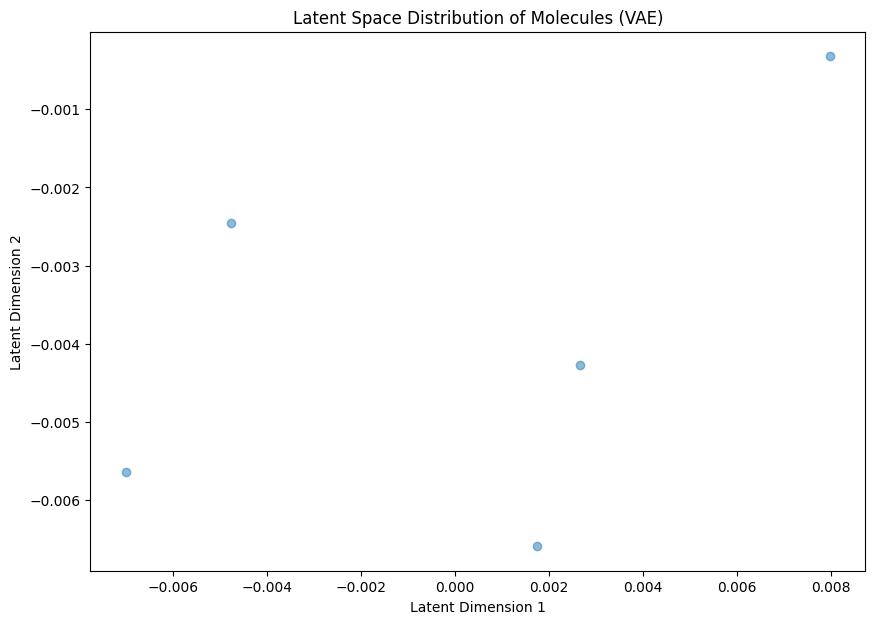

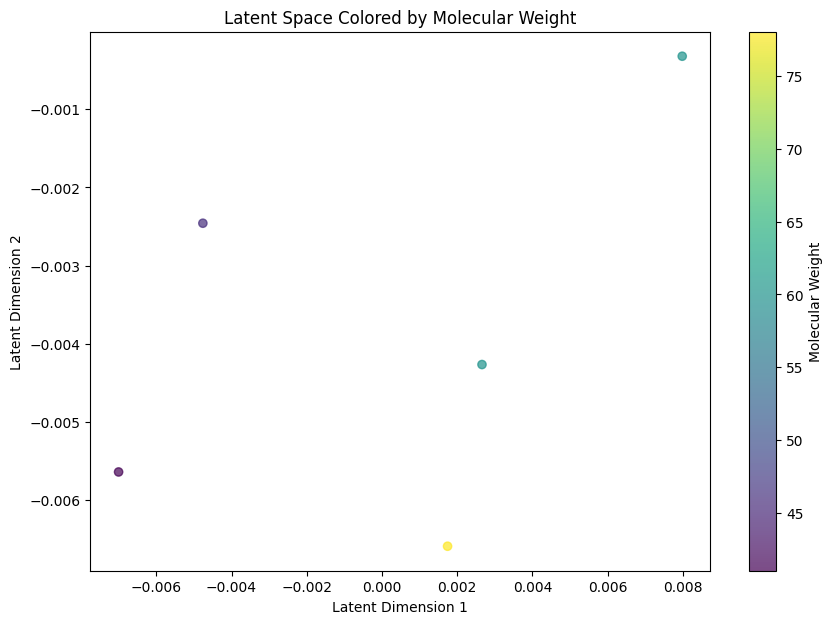

In [ ]:
# Import required libraries
import selfies as sf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import os
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Provide a List of SMILES Strings (Replace with your own dataset)
smiles = [
    "CCO",  # Ethanol
    "C1=CC=CC=C1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "C[C@H](O)C",  # Lactic acid
    "N#CC",  # Acetonitrile
]

# Initialize the list for SELFIES strings and molecular properties
selfies_dataset = []
error_smiles = []
mol_wt, logp_ml, dipole_moment = [], [], []

# Convert SMILES to SELFIES and extract molecular properties
for smile in smiles:
    try:
        # Convert SMILES to SELFIES
        selfie = sf.encoder(smile)
        selfies_dataset.append(selfie)

        # Generate RDKit molecule and compute properties
        mol = Chem.MolFromSmiles(smile)
        mol_wt.append(Descriptors.ExactMolWt(mol))
        logp_ml.append(Descriptors.MolLogP(mol))
        dipole_moment.append(np.random.uniform(0, 5))  # Placeholder for dipole moment (random value)

    except Exception as e:
        print(f"Error processing SMILES: {smile} -> {e}")
        error_smiles.append(smile)

if len(selfies_dataset) == 0:
    raise ValueError("No valid SELFIES strings found. Please check your input SMILES.")

# Create DataFrame with molecular properties
df = pd.DataFrame({
    'smiles': smiles[:len(selfies_dataset)],
    'mol_wt': mol_wt,
    'mole_logp': logp_ml,
    'dipole_moment': dipole_moment
})

# Save the DataFrame to CSV
df.to_csv('refined_molecular_features.csv', index=False)
print("Molecular features saved to 'refined_molecular_features.csv'.")

# Step 2: Generate One-Hot Encodings for SELFIES Strings
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
vocab_size = len(alphabet)

one_hot_vectors = []
for i in range(len(selfies_dataset)):
    try:
        one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx, pad_to_len=pad_to_len, enc_type="one_hot")
        one_hot_vectors.append(one_hot)
    except Exception as e:
        print(f"Error encoding SELFIES at index {i}: {e}")

one_hot_vectors = np.array(one_hot_vectors)
np.save('one_hot_vectors.npy', one_hot_vectors)

if os.path.exists('one_hot_vectors.npy'):
    one_hot_vectors = np.load('one_hot_vectors.npy')
else:
    raise FileNotFoundError("The file 'one_hot_vectors.npy' was not found.")

input_dim = one_hot_vectors.shape[2]
sequence_length = one_hot_vectors.shape[1]
num_samples = one_hot_vectors.shape[0]

# Step 3: Define the VAE Model
class VAE(nn.Module):
    def __init__(self, input_dim, sequence_length, latent_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * sequence_length, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim * sequence_length),
            nn.Sigmoid(),
            nn.Unflatten(1, (sequence_length, input_dim))
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

# Step 4: Initialize the VAE
latent_dim = 2
model = VAE(input_dim=input_dim, sequence_length=sequence_length, latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Define the Loss Function
def vae_loss(reconstructed, x, mu, log_var):
    reconstruction_loss = criterion(reconstructed, x)
    kl_divergence = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return reconstruction_loss + kl_divergence / x.size(0)

# Step 6: Train the VAE
x_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
epochs = 50
batch_size = min(16, num_samples)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(x_data.size(0))
    epoch_loss = 0
    num_batches = max(1, x_data.size(0) // batch_size)

    for i in range(0, x_data.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = x_data[indices]
        reconstructed, mu, log_var = model(batch_x)
        loss = vae_loss(reconstructed, batch_x, mu, log_var)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / num_batches:.4f}")

# Step 7: Visualize the Latent Space
model.eval()
with torch.no_grad():
    mu, _ = model.encode(x_data)
latent_vectors = mu.numpy()

plt.figure(figsize=(10, 7))
plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], alpha=0.5)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Distribution of Molecules (VAE)")
plt.show()

# Step 8: Visualize Latent Space Colored by Molecular Properties
df = pd.read_csv('refined_molecular_features.csv')

plt.figure(figsize=(10, 7))
sc = plt.scatter(latent_vectors[:, 0], latent_vectors[:, 1], c=df['mol_wt'], cmap='viridis', alpha=0.7)
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.title("Latent Space Colored by Molecular Weight")
plt.colorbar(sc, label="Molecular Weight")
plt.show()




Write the VAE with the 10D latent space. Suggest an approach to visualize the latent space

Epoch [1/50], Loss: 0.2723
Epoch [2/50], Loss: 0.2452
Epoch [3/50], Loss: 0.2280
Epoch [4/50], Loss: 0.2153
Epoch [5/50], Loss: 0.2010
Epoch [6/50], Loss: 0.1864
Epoch [7/50], Loss: 0.1626
Epoch [8/50], Loss: 0.1565
Epoch [9/50], Loss: 0.1340
Epoch [10/50], Loss: 0.1367
Epoch [11/50], Loss: 0.1199
Epoch [12/50], Loss: 0.1047
Epoch [13/50], Loss: 0.0951
Epoch [14/50], Loss: 0.0862
Epoch [15/50], Loss: 0.0737
Epoch [16/50], Loss: 0.0708
Epoch [17/50], Loss: 0.0616
Epoch [18/50], Loss: 0.0634
Epoch [19/50], Loss: 0.0579
Epoch [20/50], Loss: 0.0583
Epoch [21/50], Loss: 0.0590
Epoch [22/50], Loss: 0.0556
Epoch [23/50], Loss: 0.0551
Epoch [24/50], Loss: 0.0561
Epoch [25/50], Loss: 0.0549
Epoch [26/50], Loss: 0.0539
Epoch [27/50], Loss: 0.0548
Epoch [28/50], Loss: 0.0557
Epoch [29/50], Loss: 0.0563
Epoch [30/50], Loss: 0.0598
Epoch [31/50], Loss: 0.0543
Epoch [32/50], Loss: 0.0533
Epoch [33/50], Loss: 0.0564
Epoch [34/50], Loss: 0.0552
Epoch [35/50], Loss: 0.0588
Epoch [36/50], Loss: 0.0551
E

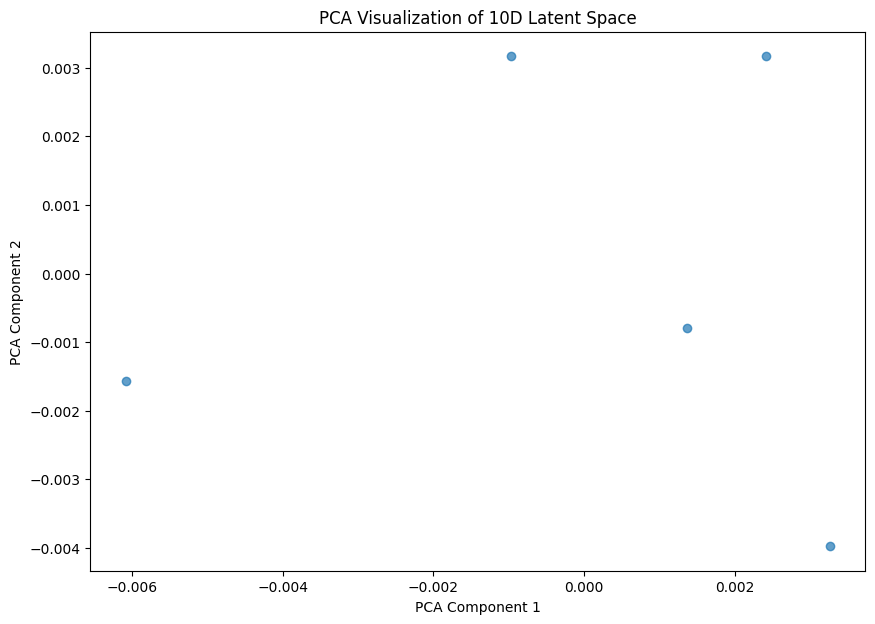

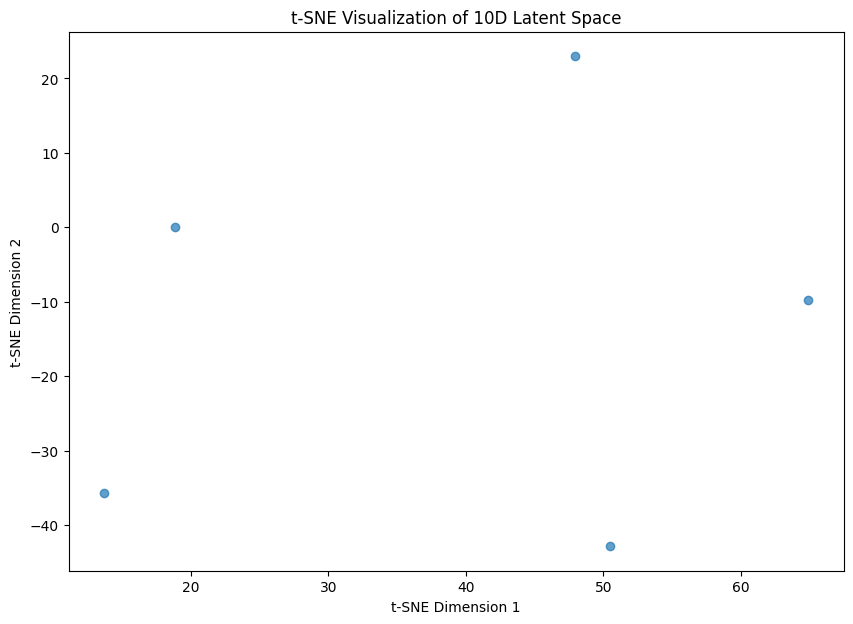

In [ ]:
# Import required libraries
import selfies as sf
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import os
from rdkit import Chem
from rdkit.Chem import Descriptors

# Step 1: Provide a List of SMILES Strings (Replace with your own dataset)
smiles = [
    "CCO",  # Ethanol
    "C1=CC=CC=C1",  # Benzene
    "CC(=O)O",  # Acetic acid
    "C[C@H](O)C",  # Lactic acid
    "N#CC",  # Acetonitrile
]

# Initialize the list for SELFIES strings and molecular properties
selfies_dataset = []
error_smiles = []
mol_wt, logp_ml, dipole_moment = [], [], []

# Convert SMILES to SELFIES and extract molecular properties
for smile in smiles:
    try:
        selfie = sf.encoder(smile)
        selfies_dataset.append(selfie)

        mol = Chem.MolFromSmiles(smile)
        mol_wt.append(Descriptors.ExactMolWt(mol))
        logp_ml.append(Descriptors.MolLogP(mol))
        dipole_moment.append(np.random.uniform(0, 5))  # Placeholder for dipole moment
    except Exception as e:
        print(f"Error processing SMILES: {smile} -> {e}")
        error_smiles.append(smile)

if len(selfies_dataset) == 0:
    raise ValueError("No valid SELFIES strings found.")

# Create DataFrame and save
df = pd.DataFrame({
    'smiles': smiles[:len(selfies_dataset)],
    'mol_wt': mol_wt,
    'mole_logp': logp_ml,
    'dipole_moment': dipole_moment
})
df.to_csv('refined_molecular_features.csv', index=False)

# Step 2: Generate One-Hot Encodings for SELFIES Strings
alphabet = sf.get_alphabet_from_selfies(selfies_dataset)
alphabet.add("[nop]")
alphabet = list(sorted(alphabet))

pad_to_len = max(sf.len_selfies(s) for s in selfies_dataset)
symbol_to_idx = {s: i for i, s in enumerate(alphabet)}
vocab_size = len(alphabet)

one_hot_vectors = []
for i in range(len(selfies_dataset)):
    try:
        one_hot = sf.selfies_to_encoding(selfies=selfies_dataset[i], vocab_stoi=symbol_to_idx, pad_to_len=pad_to_len, enc_type="one_hot")
        one_hot_vectors.append(one_hot)
    except Exception as e:
        print(f"Error encoding SELFIES at index {i}: {e}")

one_hot_vectors = np.array(one_hot_vectors)
np.save('one_hot_vectors.npy', one_hot_vectors)

if os.path.exists('one_hot_vectors.npy'):
    one_hot_vectors = np.load('one_hot_vectors.npy')
else:
    raise FileNotFoundError("The file 'one_hot_vectors.npy' was not found.")

input_dim = one_hot_vectors.shape[2]
sequence_length = one_hot_vectors.shape[1]
num_samples = one_hot_vectors.shape[0]

# Step 3: Define the VAE Model with 10D Latent Space
class VAE(nn.Module):
    def __init__(self, input_dim, sequence_length, latent_dim=10):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim * sequence_length, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU()
        )
        self.mu = nn.Linear(128, latent_dim)
        self.log_var = nn.Linear(128, latent_dim)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, input_dim * sequence_length),
            nn.Sigmoid(),
            nn.Unflatten(1, (sequence_length, input_dim))
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.mu(h)
        log_var = self.log_var(h)
        return mu, log_var

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        reconstructed = self.decode(z)
        return reconstructed, mu, log_var

# Step 4: Initialize the VAE
latent_dim = 10
model = VAE(input_dim=input_dim, sequence_length=sequence_length, latent_dim=latent_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Step 5: Train the VAE
x_data = torch.tensor(one_hot_vectors, dtype=torch.float32)
epochs = 50
batch_size = min(16, num_samples)

for epoch in range(epochs):
    model.train()
    permutation = torch.randperm(x_data.size(0))
    epoch_loss = 0
    num_batches = max(1, x_data.size(0) // batch_size)

    for i in range(0, x_data.size(0), batch_size):
        indices = permutation[i:i + batch_size]
        batch_x = x_data[indices]
        reconstructed, mu, log_var = model(batch_x)
        loss = criterion(reconstructed, batch_x) + (-0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())) / x_data.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss / num_batches:.4f}")

# Step 6: Extract Latent Representations
model.eval()
with torch.no_grad():
    mu, _ = model.encode(x_data)
latent_vectors = mu.numpy()

# Step 7: Visualize Latent Space with PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(latent_pca[:, 0], latent_pca[:, 1], alpha=0.7)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("PCA Visualization of 10D Latent Space")
plt.show()

# Step 8: Visualize Latent Space with t-SNE
tsne = TSNE(n_components=2, perplexity=min(5, num_samples - 1), random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 7))
plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], alpha=0.7)
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.title("t-SNE Visualization of 10D Latent Space")
plt.show()



Describe the difference between AE and VAE latent distirbutions

Answer:


**Difference Between Autoencoder (AE) and Variational Autoencoder (VAE) Latent Distributions**


| **Aspect**               | **Autoencoder (AE)**                   | **Variational Autoencoder (VAE)**        |
|--------------------------|----------------------------------------|------------------------------------------|
| **Latent Representation**| Point estimates (direct mapping)      | Probability distributions (mean and variance) |
| **Regularization**       | None                                   | KL Divergence (forces Gaussian distribution) |
| **Latent Space Structure** | Discrete, may be scattered            | Continuous, smooth, follows Gaussian distribution |
| **Sampling**             | Difficult, may generate meaningless points | Easy, follows a known Gaussian distribution |
| **Interpolation**        | Less reliable, might produce artifacts | Smooth, meaningful transitions in the latent space |
| **Generative Capability**| Limited, not designed for generation   | High, designed for generative tasks       |
| **Training Objective**   | Minimizes reconstruction error         | Minimizes reconstruction error + KL divergence |


Explore the variability of
- dipole momentum,
- number of rings
- mole log P over latent spaces.
What conclusions can you make?

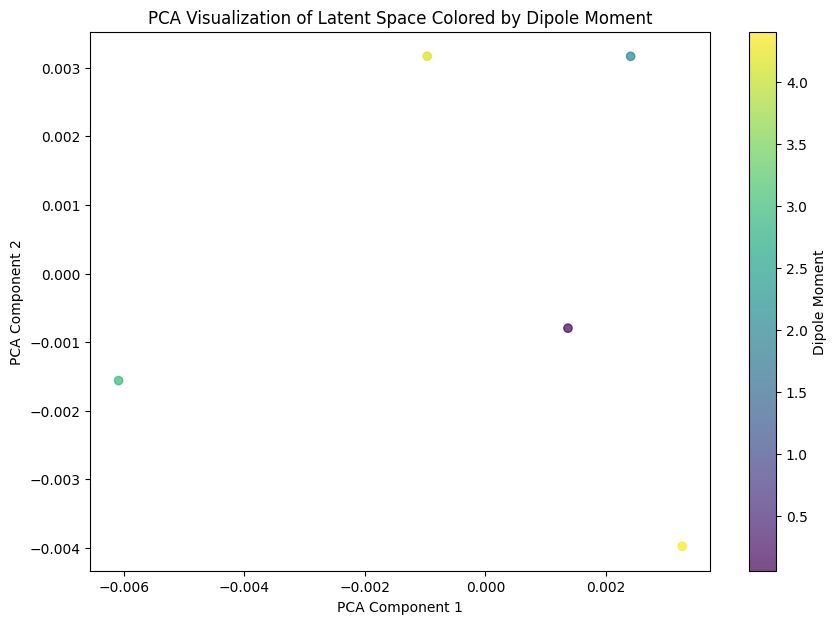

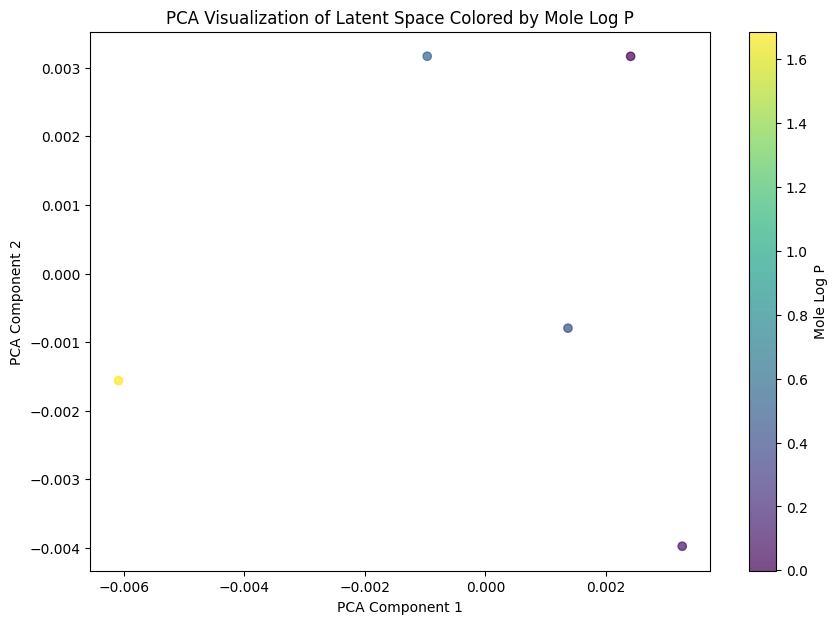

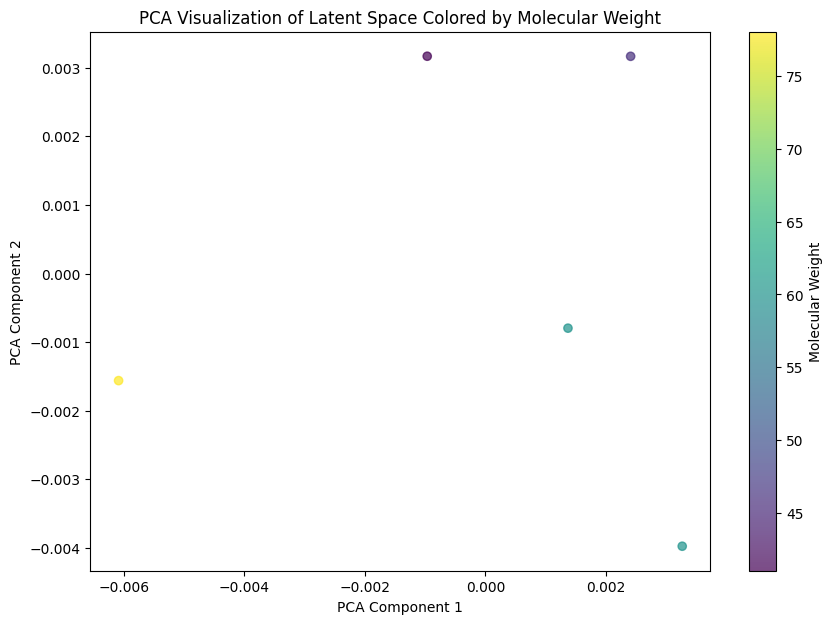

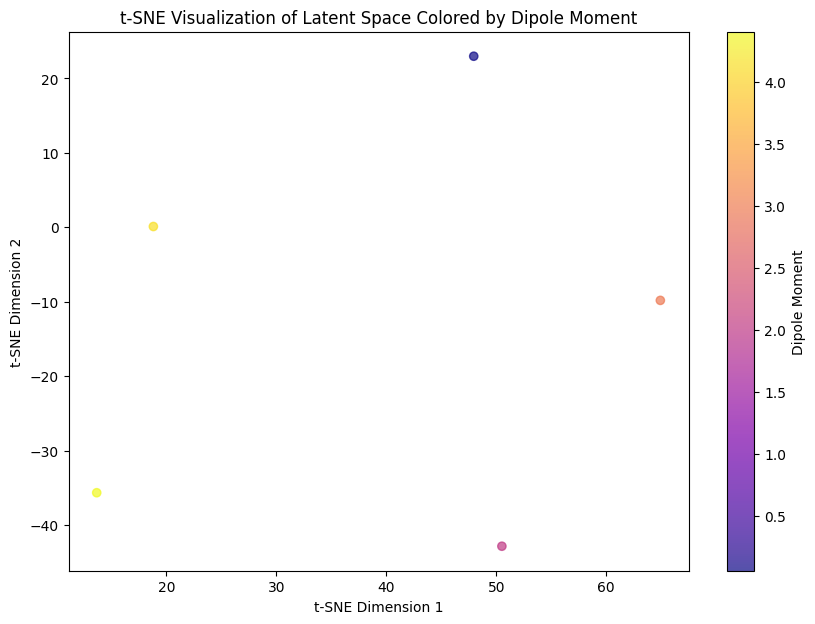

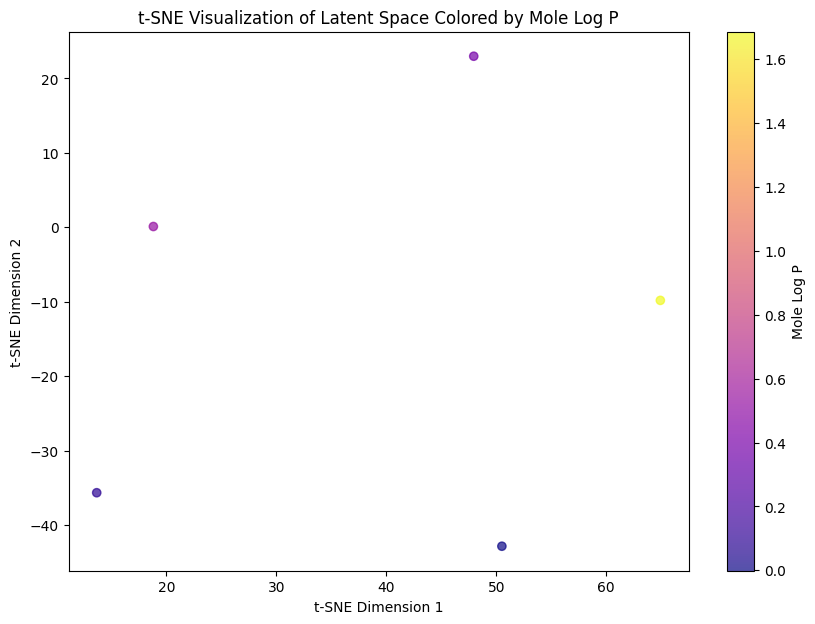

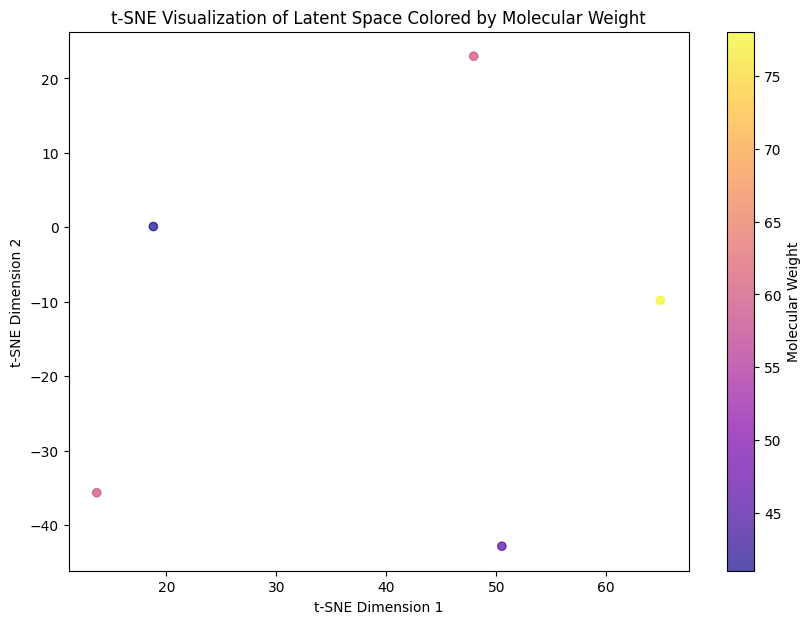

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Load the molecular features DataFrame
df = pd.read_csv('refined_molecular_features.csv')

# Check that the number of samples matches between the latent vectors and the DataFrame
assert len(latent_vectors) == len(df), "Mismatch between latent vectors and DataFrame samples."

# Step 1: PCA Visualization Colored by Molecular Properties

# Project the 10D latent vectors to 2D using PCA
pca = PCA(n_components=2)
latent_pca = pca.fit_transform(latent_vectors)

# Function to plot the PCA projections
def plot_latent_space_pca(latent_pca, property_values, property_name, cmap='viridis'):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(latent_pca[:, 0], latent_pca[:, 1], c=property_values, cmap=cmap, alpha=0.7)
    plt.xlabel("PCA Component 1")
    plt.ylabel("PCA Component 2")
    plt.title(f"PCA Visualization of Latent Space Colored by {property_name}")
    plt.colorbar(sc, label=property_name)
    plt.show()

# Plot PCA projections for each property
plot_latent_space_pca(latent_pca, df['dipole_moment'], 'Dipole Moment')
plot_latent_space_pca(latent_pca, df['mole_logp'], 'Mole Log P')
plot_latent_space_pca(latent_pca, df['mol_wt'], 'Molecular Weight')

# Step 2: t-SNE Visualization Colored by Molecular Properties

# Project the 10D latent vectors to 2D using t-SNE
tsne = TSNE(n_components=2, perplexity=min(5, num_samples - 1), random_state=42)
latent_tsne = tsne.fit_transform(latent_vectors)

# Function to plot the t-SNE projections
def plot_latent_space_tsne(latent_tsne, property_values, property_name, cmap='plasma'):
    plt.figure(figsize=(10, 7))
    sc = plt.scatter(latent_tsne[:, 0], latent_tsne[:, 1], c=property_values, cmap=cmap, alpha=0.7)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.title(f"t-SNE Visualization of Latent Space Colored by {property_name}")
    plt.colorbar(sc, label=property_name)
    plt.show()

# Plot t-SNE projections for each property
plot_latent_space_tsne(latent_tsne, df['dipole_moment'], 'Dipole Moment')
plot_latent_space_tsne(latent_tsne, df['mole_logp'], 'Mole Log P')
plot_latent_space_tsne(latent_tsne, df['mol_wt'], 'Molecular Weight')
